Nama = Anas Fikri Hanif\
SIB ID = M183X0321

**Import Library**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

**Menyaipkan Dataset**

In [10]:
df = pd.read_csv('AEP_hourly.csv')
df

,Datetime,AEP_MW
0,2016-12-31 01:00:00,14877.0
1,2016-12-31 02:00:00,14588.0
2,2016-12-31 03:00:00,14514.0
3,2016-12-31 04:00:00,14591.0
4,2016-12-31 05:00:00,14604.0
...,...,...
22674,2018-01-01 20:00:00,21089.0
22675,2018-01-01 21:00:00,20999.0
22676,2018-01-01 22:00:00,20820.0
22677,2018-01-01 23:00:00,20415.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22679 entries, 0 to 22678
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  22679 non-null  object 
 1   AEP_MW    22679 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.5+ KB


**Membuat Plot**

Text(0.5, 1.0, 'American Electric Power')

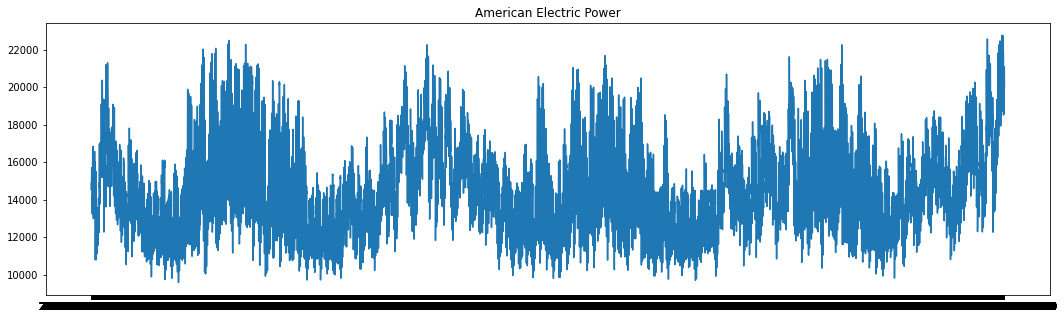

In [12]:
date = df['Datetime'].values
consumption = df['AEP_MW'].values # energy consumption

plt.figure(figsize=(18, 5))
plt.plot(date, consumption)
plt.title('American Electric Power')

**Data Scaler**

In [14]:
consumption = consumption.reshape(-1, 1)

minmax_scaler = MinMaxScaler()
scaled_consumption = minmax_scaler.fit_transform(consumption)
scaled_consumption = scaled_consumption.reshape(1, -1)
scaled_consumption = np.hstack(scaled_consumption)

**Splitting Train dan Test**

In [15]:
# data validation sebesar 20%
x_train, x_test, y_train, y_test = train_test_split(date, scaled_consumption, test_size=0.2, random_state=1, shuffle=False)

**Formatting Data**

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

**Modelling Data**

In [17]:
train_set = windowed_dataset(y_train, window_size=90, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=90, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [18]:
optimizer = tf.keras.optimizers.SGD(lr=1.000e-01, momentum=0.9)

model.compile(loss='Huber',
              optimizer = optimizer,
              metrics = ['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


**Pembuatan Callback**

In [19]:
# mencari 10% skala data
data_scale = (max(scaled_consumption) - min(scaled_consumption)) * 0.1
print(data_scale)

0.1


In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae') < data_scale) and (logs.get('val_mae') < data_scale):
      self.model.stop_training = True,
      print('\nMAE mencapai dibawah 10% dari skala data!')

callbacks = myCallback()

**Fitting Data**

In [23]:
history = model.fit(
    train_set, 
    epochs = 100,
    validation_data = val_set,
    verbose = 2,
    callbacks = [callbacks]
)

Epoch 1/100
181/181 - 41s - loss: 0.0156 - mae: 0.1400 - val_loss: 0.0098 - val_mae: 0.1105 - 41s/epoch - 226ms/step
Epoch 2/100
181/181 - 34s - loss: 0.0092 - mae: 0.1066 - val_loss: 0.0055 - val_mae: 0.0824 - 34s/epoch - 187ms/step
Epoch 3/100

MAE mencapai dibawah 10% dari skala data!
181/181 - 32s - loss: 0.0039 - mae: 0.0695 - val_loss: 0.0037 - val_mae: 0.0673 - 32s/epoch - 179ms/step


**Pembuatan Plot MAE dan Plot Loss**

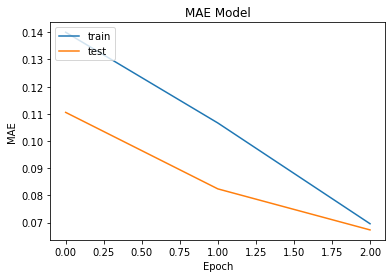

In [24]:
# plot mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

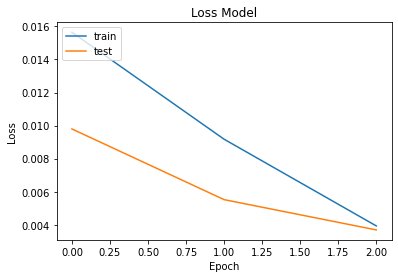

In [25]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()